## Super Resolution Tutorial
There are many methods to recover a high-resolution (HR) image from several low-resolution (LR) images. The first to suggest such a method were Tsai and Huang$^{1}$. Their method is performed in the spectral domain (e.g., post-Fourier transform). More methods have since come out that are performed in the native spatial domain. The main methods are iterative backprojection (IBT)$^{2}$, projection onto convex sets (POCS)$^{3}$, and method based on maximum a posteriori (MAP)$^{4}$. There are also hybrid POCS/MAP methods. 

Below I will try to implement a crude method, developed by Peleg, Keren, and Schweitzer$^{5, 6}$ (PKS) that was developed before Irani and Peleg applied IBP to the super-resolution problem. In this method, LR images are sub-pixel displaced (i.e. either the subject of the image or the sensing camera are displaced by a distance where distance modulo pixel length != 0. The images are then sub-pixel registered (for this, I will use cross correlation in the spectral domain), and then an HR intial guess is generated from an average of the LRs. Then the imaging process is then simulated from the HR initial guess, and an error is calculated between the observed and generated LR images, and the HR image is adjusted to minimize the error. This is repeated until a certain number of iterations is reached or the error is small enough.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
from skimage.feature import register_translation
from skimage.feature.register_translation import _upsampled_dft
import scipy.ndimage as spimg
from scipy.ndimage import fourier_shift
from scipy.ndimage import shift as sp_shift
from scipy import stats
from tqdm import tqdm_notebook as tqdm
import itertools as it
from copy import copy

First some functions for just visualizing images.

In [2]:
def rgb2gray(rgb):
    # convert 3-channel JPEG to grayscale
    return 255 - np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]) 

def showme(img, title=None):
    # show in black and white
    plt.imshow(img, cmap='binary');
    plt.title(title)

In [3]:
# read original image and downsize for speed
Xorig = rgb2gray(plt.imread('/myvol/data/puppy-dog.jpg')) # read in grayscale

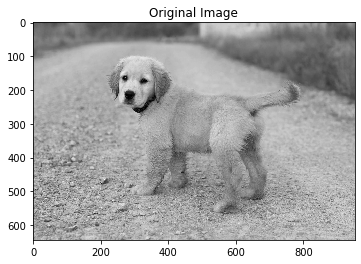

In [4]:
showme(Xorig,'Original Image')

In [298]:
# I want a square image with a border
# Xcrop = Xorig[22:622,202:802] # square it with the dog in the center of the image, 600 x 600 pixels
Xcrop = Xorig[80:280,210:410] # square it with the dog face in the center of the image, 150 x 150 pixels
# Xcrop = Xorig[200:240,220:260] # square it with a really small part of picture

Going to pad the image to replicate the genomic picture in the middle of the microwell array.

In [309]:
pad = 50
X = np.pad(Xcrop,pad_width=pad,mode='constant',constant_values=0)

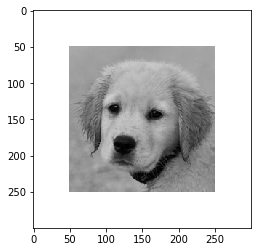

In [310]:
showme(X)

In [311]:
shifts = list()
imgs = list()
for _ in range(9):

    # take two random number of pixels by which to displace the central image 
    shift = np.random.choice(range(-pad,pad+1),2) 
    shifts.append(shift)
    
    # The shift corresponds to the pixel offset relative to the reference image
    imgs.append(sp_shift(X,shift))

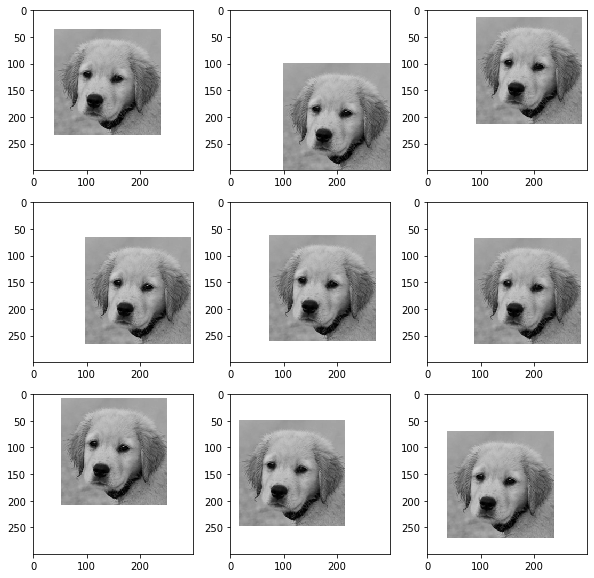

In [312]:
fig, axes = plt.subplots(3,3,figsize=(10,10))
for img, ax in zip(imgs,np.ravel(axes)):
    ax.imshow(img,cmap='binary')

For reducing resolution, I'm using the `skimage.meaure.block_reduce()` function, which I think makes most sense for genomic picture. All the `resize()` or `zoom()` functions tend to have some edge effects around the border of the image, which will skew results. To represent multiple nuclei in one well, I will probably opt to just average (or sum) over feature counts of all nuclei in the well. I opt to use the average.

The `skimage.meaure.block_reduce()` function will pad the array with zeros if the reduction is not by a factor of the axis length. This will obviously skew results. For this reason, I want to make sure I'm using a factor.

In [313]:
def print_factors(x):
    factors = list()
    for i in range(1, x + 1):
        if x % i == 0:
            if (int(x/i), i) not in factors:
                factors.append((i, int(x/i)))
            else:
                break
    return factors

In [314]:
print_factors(len(imgs[0][0]))

[(1, 300),
 (2, 150),
 (3, 100),
 (4, 75),
 (5, 60),
 (6, 50),
 (10, 30),
 (12, 25),
 (15, 20)]

Now apply the blockreduce function.

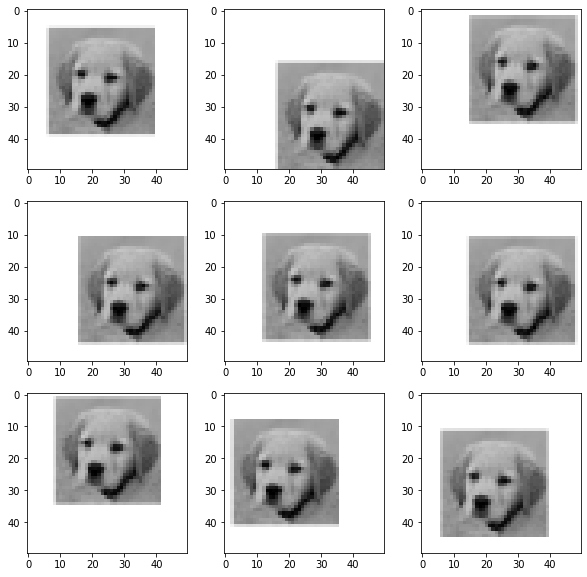

In [316]:
scale = 6
    
def myblockreduce(img, scale):
    return np.round(skimage.measure.block_reduce(img, (scale, scale),func=np.mean))

LRimgs = [myblockreduce(i,scale) for i in imgs] 
fig, axes = plt.subplots(3,3,figsize=(10,10))
for img, ax in zip(LRimgs,np.ravel(axes)):
    ax.imshow(img,cmap='binary')

Now, in order to do subpixel registration, I'm going to utilize this registration algorithm from scikit image. This uses the cross correlation in Fourier space to register two images to arbitrary subpixel precision.

In [317]:
image_1 = LRimgs[0]
for i in range(1,9):
    est_shift, error, diffphase = register_translation(image_1, LRimgs[i], scale) # let's recover the same image resolution
    print(est_shift)

[-10.83333333 -10.        ]
[ 3.66666667 -8.5       ]
[-5.16666667 -9.5       ]
[-4.33333333 -5.66666667]
[-5.33333333 -8.16666667]
[ 4.5 -2. ]
[-2.16666667  4.        ]
[-5.83333333  0.33333333]


In [318]:
scaled_shift_1 = shifts[0]/scale
for i in range(1,9):
    true_scaled_shift = scaled_shift_1 - shifts[i]/scale
    print(true_scaled_shift)

[-10.83333333 -10.        ]
[ 3.66666667 -8.5       ]
[-5.16666667 -9.5       ]
[-4.33333333 -5.66666667]
[-5.33333333 -8.16666667]
[ 4.5 -2. ]
[-2.16666667  4.        ]
[-5.83333333  0.33333333]


Wow, the `register_translation()` function is extremely accurate, even at a much lower resolution than the original. I wonder what the correlation is.

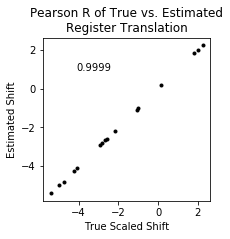

In [349]:
image_1 = LRimgs[0]
scaled_shift_1 = shifts[0]/scale
xs = list()
ys = list()
for i in range(1,9):
    est_shift, error, diffphase = register_translation(image_1, LRimgs[i], scale)
    true_scaled_shift = scaled_shift_1 - shifts[i]/scale
    xs.append(true_scaled_shift)
    ys.append(est_shift)

# flatten the list of arrays
xs = [i for j in xs for i in j]
ys = [i for j in ys for i in j]
plt.figure(figsize=(3,3))
plt.plot(xs, ys,linewidth=0, marker='.', color='k');
plt.text(0.2,0.8,str(stats.pearsonr(xs,ys)[0])[:6],transform=plt.gca().transAxes);
plt.title('Pearson R of True vs. Estimated\nRegister Translation');
plt.xlabel('True Scaled Shift');
plt.ylabel('Estimated Shift');

## Just for fun...
...let's see how the error varies over the resolution of the images.

In [320]:
# want to go from extremely low resolution (2 pixels) to 1/2 resolution (len(img)/2)
# scales will be reversed, since scale=1/resolution
half_length = len(imgs[0][0])/2
scales = np.arange(2,half_length + 1,1,dtype='int')[::-1]

ys = list()
for scale in tqdm(scales):
    LRimgs = [myblockreduce(i,scale) for i in imgs]
    image_1 = LRimgs[0]
    scaled_shift_1 = shifts[0]/scale
    errors = list()
    for i in range(1,9):
        est_shift, error, diffphase = register_translation(image_1, LRimgs[i], 100) # let's just use 100x resolution increase herre
        true_scaled_shift = scaled_shift_1 - shifts[i]/scale
        error = abs(est_shift - true_scaled_shift)
        errors.append(np.mean(error))
    ys.append(np.mean(errors))

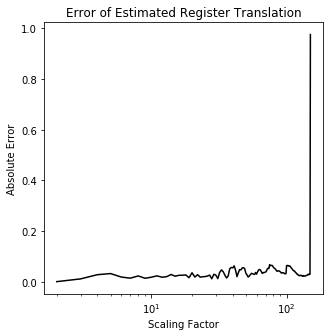

In [321]:
plt.figure(figsize=(5,5))
plt.plot(scales, ys, color='k');
plt.xscale('log');
plt.xlabel('Scaling Factor');
plt.ylabel('Absolute Error');
plt.title('Error of Estimated Register Translation');

Nice. There are definitely come interesting jumps in error towards the end. I have a feeling they correspond to where the scale is a factor of the original pixel length.

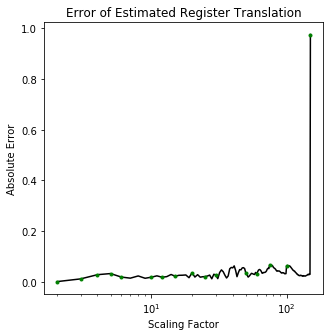

In [322]:
# plot original graph
plt.figure(figsize=(5,5))
plt.plot(scales, ys, color='k');

factors = print_factors(len(imgs[0][0]))
# the indices in scales that are equal to the factors of 780 (our original pixel length)
indices = list(int(half_length) - np.array(sorted([i for j in factors[1:] for i in j])))
plt.plot(scales, ys, linewidth=0, marker='.', color='green', markevery = indices);

plt.xscale('log');
plt.xlabel('Scaling Factor');
plt.ylabel('Absolute Error');
plt.title('Error of Estimated Register Translation');

Curious as to why this is. It might have to do with the padding `block_reduce()` does when the requested scale is not a perfect factor of the original pixel length. It's adding zeroes, and since our white background is also zeros, perhaps it makes the mean error smaller. Might be good to test with a background of noise (or black background, or different padding value). Anyways, no need to explore further now. Even though they're higher error, I'm still going to use only factors of the original pixel length to not introduce these artifacts.

## Back to the Pipeline

#### Simulate "_observed_" LR images
These would be the LR images we observe from the assay. To make it challenging, I'm going to use a resolution reduction factor of 12 (sides of pixel length 25).

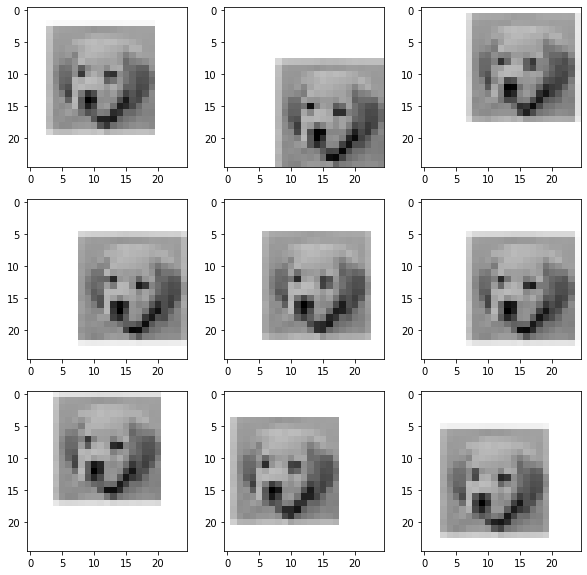

In [323]:
scale = 12
LRimgs = [myblockreduce(i,scale) for i in imgs]
fig, axes = plt.subplots(3,3,figsize=(10,10))
for img, ax in zip(LRimgs,np.ravel(axes)):
    ax.imshow(img,cmap='binary')

#### Calculate subpixel displacement

In [324]:
est_shifts = list()
image_1 = LRimgs[0]
for i in range(1,9):
    est_shift, error, diffphase = register_translation(image_1, LRimgs[i], scale)
    est_shifts.append(est_shift)

#### Register frames

In order to move the images at sub-pixel precision, I'm going to resize the image first. Unfortunately, all the image resizing implementations I found only have nearest neighbor as the simplest. This won't be true to the original algorithm: if I want to upscale, e.g., by 5, I need all `5^2 - 1 = 24` extra pixels in the resized image to be derived from a single value. Nearest neighbors will allocate extra pixels to the nearest original pixel. I need to use kronecker delta `np.kron()`.

In [325]:
LRresz = [np.kron(img, np.ones((scale,scale))) for img in LRimgs] # LRresz = low resolution, resized
LRreszreg = [LRresz[0]] + [sp_shift(i,j*scale) for i, j in zip(LRresz[1:],est_shifts)] # LRreszreg = LRresz + registered

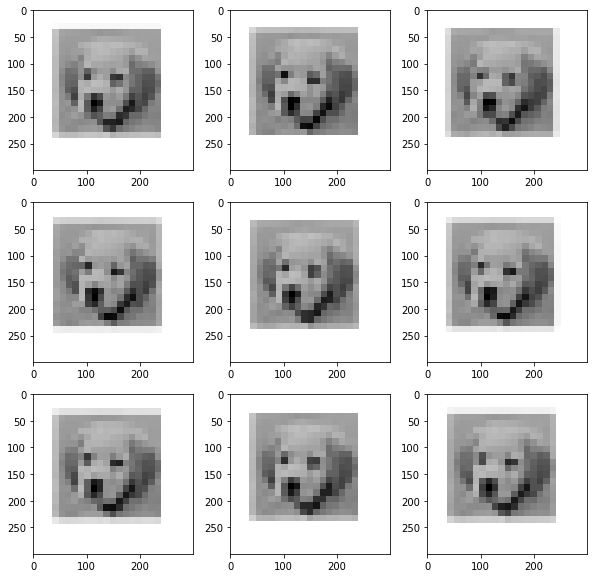

In [326]:
fig, axes = plt.subplots(3,3,figsize=(10,10))
for img, ax in zip(LRreszreg,np.ravel(axes)):
    ax.imshow(img,cmap='binary')

#### Make initial HR guess

In [327]:
stacked = np.stack(LRreszreg,axis=2) # stack all registered images

PKS use the average of the middle 50% of pixel values to collapse for the initial HRguess because they showed it works well. I ran both that method and just the regular mean of all values (not shown), and they looked very similar. The mean takes a fraction of the time to calculate, so I'm just going to use that.

In [328]:
HRguess = np.abs(np.round(np.apply_along_axis(np.mean,2,stacked))) # take the mean, then round

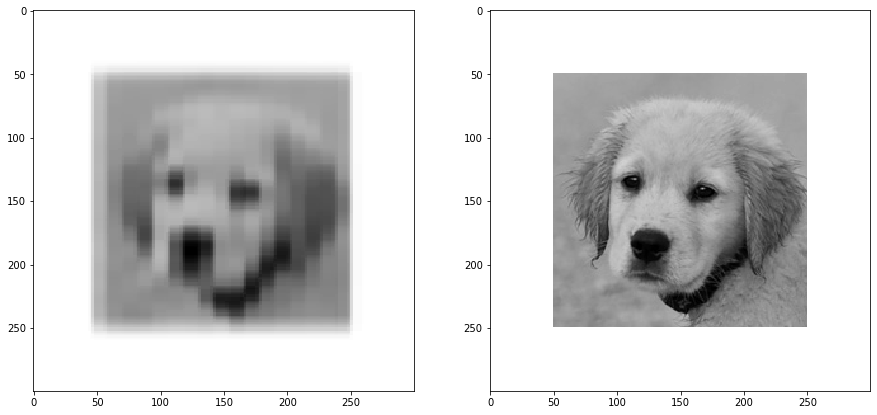

In [329]:
fig, axes = plt.subplots(1,2,figsize=(15,10))
for img, ax in zip((sp_shift(HRguess,-shifts[0]),X), np.ravel(axes)): # shift it back to center, just to compare
    ax.imshow(img,cmap='binary')

This should be interesting, it looks really crappy.

I would only like to focus on the part of the image that has the image. I don't think it makes sense to change part of the image that don't have _any_ signal.

In [343]:
length = len(HRguess)
x1 = y1 = -1
for i in range(length):
    if HRguess[i,:].max() != 0:
        y0 = i
        break
for i in range(length):
    if HRguess.T[i,:].max() != 0:
        x0 = i
        break
for i in range(y0,length):
    if HRguess[i,:].max() == 0:
        y1 = i
        break
for i in range(x0,length):
    if HRguess.T[i,:].max() == 0:
        x1 = i
        break
if x1 == -1:
    x1 = len(HRguess)
if y1 == -1:
    y1 = len(HRguess)

In [344]:
print((x0,y0),(x1,y1))

(33, 24) (251, 245)


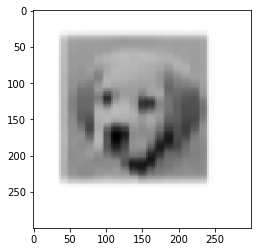

In [345]:
showme(HRguess)

Coordinates make sense!

I would also like to change the `myblockreduce()` function. I realized that after the rounding, the error getting produced was the same across all three considered cases (+/- increment or no change). Removing the rounding allows for minor fluctuations in overall error.

In [346]:
def myblockreduce(img, scale):
    return skimage.measure.block_reduce(img, (scale, scale),func=np.mean)

def simLR(HRguess):
    simLRimgs = [HRguess] + [sp_shift(HRguess, shift) for shift in scaled_shifts]
    return [myblockreduce(i,scale) for i in simLRimgs]

def imgs_error(img_zip):
    return np.sum([np.abs(img1-img2) for img1, img2 in img_zip])

In [ ]:
incr = 1
errors = {0:0,-incr:0,incr:0}

# # Record stuff to visualize later
# inds_list = list()
# errors_list = list()

for _ in range(3): # for now, just cycle a few times, but this will be changed to "after n iterations" or "after error < threshold"
    
    # for each position in the image where the image is located
    for x, y in tqdm(it.product(range(x0,x1+1),range(y0,y1+1)),total=((x1-x0+1)*(y1-y0+1))):
        
        # initialize a dictionary
        errors = dict()
        
        # store the current value of the error
        # can possibly utilize space-time tradeoff here
        # if no change was made in previous iteration, don't recalculate the error
        errors[0] = imgs_error(zip(simLR(HRguess),LRimgs))
        
        for inc in [-incr,incr]:
            newHR = copy(HRguess)
            newval = newHR[x,y] + inc
            if newval < 0 or newval > 255: # don't result in a pixel value less than 0 or greater than 255
                continue
            else:
                newHR[x,y] = newval
            errors[inc] = imgs_error(zip(simLR(newHR),LRimgs))
            
        ind = min(errors.keys(), key=(lambda k: errors[k])) # get key of change with least error
#         inds_list.append(ind)
#         errors_list.append(errors[ind])
        HRguess[x,y] = HRguess[x,y] + ind

So this function takes an extremely long time. I would like to find a way to make it more efficient and parallelize it so it can finish faster. Even with only changing the portions of the picture that contain pixel values, it will still take 3 hours to cycle through the whole image _once_. In addition to parallizing, we can also try using less LR images, start with a smaller image, or upscaling to an HR image that is still lower resolution than the original.

### References

1. Tsai, R.; Huang, T. (1984). "Multiframe Image Restoration and Registration". Advances in Computer Vision and Image Processing. JAI Press Inc. pp. 317–339
2. M. Irani and S. Peleg, “Improving resolution by image registration,” CVGIP: Graphical Models and Image Processing, vol. 53, no. 3, pp. 231–239, 1991.
3. J. Yu, C. Xiao, and K. Su, “A method of gibbs artifact reduction for POCS super-resolution image reconstruction,” in Proceedings of the 8th International Conference on Signal Processing (ICSP '06), vol. 2, IEEE, Beijing, China, November 2006.
4. J. Chen, J. Nunez-Yanez, and A. Achim, “Video super-resolution using generalized Gaussian Markov random fields,” IEEE Signal Processing Letters, vol. 19, no. 2, pp. 63–66, 2012.
5. PKS, S. Peleg, D. Keren, and L. Schweitzer, Improving image resolution using subpixel motion, Pattern Recognit. Lett. 1987, 223-226.; 
6. D. Keren. S. Peleg, and R. Brada, Image sequence enhancement using sub-pixel displacements, in IEEE Conference on Computer Vision and Pattern Recognition. pp. 742-746. Ann Arbor, MI, June 1988

## Extra Code/Notes:
Scikit image has functions to do subpixel image registration. I use these above. I should research the papers they made the function from (who was the first person to do sub-pixel registration using cross-correlation and how does it compare to the method in PKS?)

Scikit example here: https://scikit-image.org/docs/dev/auto_examples/transform/plot_register_translation.html

Paper: https://doi.org/10.1364/OL.33.000156

### Multiprocessing Attempt

In [118]:
import ctypes as c
import numpy as np
import multiprocessing as mp

In [121]:
# then in each new process create a new numpy array using:
arr = np.frombuffer(mp_arr.get_obj()) # mp_arr and arr share the same memory
# make it two-dimensional
b = arr.reshape((n,m)) # b and arr share the same memory

In [133]:
def f(a, shape):
    a = np.frombuffer(a.get_obj())
    a = a.reshape(shape)
    print('done!')

In [134]:
n, m = 5, 5
mp_arr = mp.Array(c.c_double, n*m) # shared, can be used from multiple processes
print(np.frombuffer(mp_arr.get_obj()).shape)

(25,)


In [135]:
for i in range(1):
    p = Process(target=f, args=(mp_arr,(n,m)))
    p.start()
    p.join()

done!


In [136]:
print(np.frombuffer(mp_arr.get_obj()).shape)

(25,)


### Function for mean of the middle 50% of pixel values

In [169]:
def meanmid50(a):
    # need the equals or else percentile might yeild an empty slice
    return np.mean(a[(a >= np.percentile(a,25)) & (a <= np.percentile(a,75))])

### Manual Image Translation
This was the original way I was translating images before I found `scipy.ndimage.shift()`.

In [169]:
# translation can be achieved by taking columns from the edges and placing them on their opposite side
imgs = list()
disps = list()
for _ in range(9):
    # take two random number of pixels by which to displace the central image 
    disp = np.random.choice(range(-pad,pad+1),2) 
    
    #record the displacements to register the images later
    disps.append(disp)
    
    # order is arbitrary, first will be horizontal
    disp_x = disp[0]
    disp_y = disp[1]
    
    # move rows or columns from one side to the other
    newX = np.concatenate([X[:,disp_x:],X[:,:disp_x]],axis=1)
    newX = np.concatenate([newX[disp_y:,:],newX[:disp_y,:]],axis=0)
    
    imgs.append(newX) # add to the growing list